In [26]:
from cobra.io import read_sbml_model
from cobra.io import write_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd

In [27]:
model = read_sbml_model('data/iML1515_fs.xml')

**Checking max 5-HTP production and respective growth rate if objective value is changed to the 5-HTP export reaction**

In [28]:
# Finding the flux of the phhA reaction
with model:
    print(model.reactions.phhA)
    model.objective = model.reactions.phhA
    solution = model.optimize()
    max_5HTP_production = solution.objective_value
    print("HTP flux", max_5HTP_production)
    print("Biomass flux", solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)

phhA: o2_c + thmnp_c + trp__L_c --> hthpth_c + htrp_c
HTP flux 4.2792043399638375
Biomass flux 0.0


In [31]:
# Finding the flux of the biomass reaction with 50% phhA reaction flux
with model:
    print("original bounds", model.reactions.phhA.bounds)
    model.reactions.phhA.bounds = 0, 2.1
    model.objective = model.reactions.phhA
    print("new bounds", model.reactions.phhA.bounds)
    solution = model.optimize()
    max_5HTP_production = solution.objective_value
    print("HTP flux", max_5HTP_production)
    print("Biomass flux", solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)

original bounds (0.0, 1000.0)
new bounds (0, 2.1)
HTP flux 2.1
Biomass flux 0.0


In [309]:
# Calculating yield of 5-HTP
with model:
    model.objective = model.reactions.EX_htrp
    hydroxy_trp_production = model.optimize().objective_value
    print("Max. hydroxy_trp production [mmol gDW^-1 h^-1]:", hydroxy_trp_production)
    print("Theoretical max. yield [mmol-5htp / mmol-glc]:", hydroxy_trp_production / (-1*model.reactions.EX_glc__D_e.flux))

Max. hydroxy_trp production [mmol gDW^-1 h^-1]: 4.2792043399638375
Theoretical max. yield [mmol-5htp / mmol-glc]: 0.42792043399638374


**Observing how the growth rate changes with increasing 5-HTP export flux**

In [310]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope

In [311]:
ppp_5HTP = production_envelope(model,
                    reactions=[model.reactions.phhA],
                    objective=model.reactions.BIOMASS_Ec_iML1515_core_75p37M)

In [312]:
ppp_5HTP

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,phhA
0,EX_glc__D_e,0.0,0.0,NaN,0.876997,1.161751e+01,NaN,0.000000
1,EX_glc__D_e,0.0,0.0,NaN,0.831248,1.101147e+01,NaN,0.225221
2,EX_glc__D_e,0.0,0.0,NaN,0.785499,1.040543e+01,NaN,0.450443
3,EX_glc__D_e,0.0,0.0,NaN,0.739749,9.799397e+00,NaN,0.675664
4,EX_glc__D_e,0.0,0.0,NaN,0.694000,9.193359e+00,NaN,0.900885
5,EX_glc__D_e,0.0,0.0,NaN,0.647766,8.580901e+00,NaN,1.126106
6,EX_glc__D_e,0.0,0.0,NaN,0.601497,7.967979e+00,NaN,1.351328
7,EX_glc__D_e,0.0,0.0,NaN,0.555228,7.355058e+00,NaN,1.576549
8,EX_glc__D_e,0.0,0.0,NaN,0.508959,6.742136e+00,NaN,1.801770
9,EX_glc__D_e,0.0,0.0,NaN,0.462690,6.129215e+00,NaN,2.026992


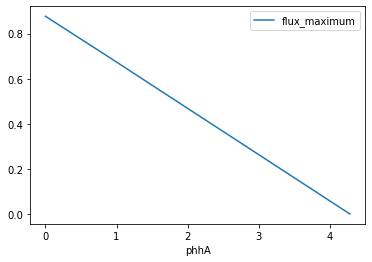

In [313]:
ppp_5HTP.plot(x='phhA', y='flux_maximum')

**Optmizing 5-HTP production and growth rate**

In [314]:
from cobra.flux_analysis import flux_variability_analysis

In [315]:
hydroxy_trp_flux_analysis = flux_variability_analysis(model, model.reactions.phhA, fraction_of_optimum = 0.5)
print(hydroxy_trp_flux_analysis)

      minimum   maximum
phhA      0.0  2.144746


In [316]:
hydroxy_trp_flux_analysis = float(flux_variability_analysis(model, model.reactions.phhA, fraction_of_optimum = 0.5)["maximum"][0])
print(hydroxy_trp_flux_analysis)

2.1447464147568795


Keeping growth rate at 50%, we get around 50% of maximum 5-HTP flux, which is bigger than in case of B.subtilis, but smaller than 1st strategy for E.coli

In [32]:
with model:
    solution = model.optimize()
    print(solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)
    model.reactions.phhA.bounds = 0, 2.14
    model.objective = model.reactions.phhA
    solution = model.optimize()
    print(solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)


0.8769972144269718
0.0


In [33]:
# Finding the flux of the phhA reaction
with model:
    print(model.reactions.phhA)
    model.reactions.phhA.bounds = 0, 2.14
    model.objective = model.reactions.phhA
    solution = model.optimize()
    max_5HTP_production = solution.objective_value
    print(max_5HTP_production)
    print(solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)

phhA: o2_c + thmnp_c + trp__L_c --> hthpth_c + htrp_c
2.14
0.0


**Knocking out a single gene and setting the objective value of the model for 5-HTP export flux**

Only non-zero biomass production flux knock-outs are selected

In [320]:
for gene in model.genes:
    with model:
        gene.knock_out()
        model.objective = model.reactions.phhA
        solution = model.optimize()
        if solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M > 0:
            print ('5-HTP export flux:', solution.fluxes.tph, 'Gene ID:', gene.id, 'Biomass production:', solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)

No solutions displayed, no single knock-outs and optmization to maximum 5-HTP production yields positive growth rate

**Knocking out a single gene, running optimisation for max biomass production flux and observing 5-HTP export flux**

Only non-zero 5-HTP export flux knock-outs are selected

In [39]:
knock_out_list = pd.DataFrame(columns=['Gene ID', '5-HTP export flux', 'Biomass production flux'])
for gene in model.genes:
    with model:
        gene.knock_out()
        solution = model.optimize()
        if solution.fluxes.phhA > 0:
            knock_out_list = knock_out_list.append({ 'Gene ID': gene.id, '5-HTP export flux': solution.fluxes.phhA, 'Biomass production flux': model.optimize().objective_value}, ignore_index=True)

In [40]:
print(knock_out_list)

Empty DataFrame
Columns: [Gene ID, 5-HTP export flux, Biomass production flux]
Index: []


No solutions, no single knock-outs give rise to positive htp flux with maximum growth rate

**Check whether change of carbon source will influence the growth rate at maximum 5-HTP flux**

In [321]:
#create list to store the reactions' IDs
carbon_uptake = list()

#go through all metabolites in the model that have carbon in their chem.structure
for metabolite in model.metabolites:
    if 'C' in metabolite.elements:
        #find metabolites that are external
        if metabolite.id[-1] == 'e':
            reactions = metabolite.reactions
            #pick reactions which exchange the metabolite with the external environment
            for element in reactions:
                if str(element.id[:2]) == 'EX':
                    carbon_uptake.append(element.id)

In [322]:
carbon_uptake

['EX_co2_e',
 'EX_akg_e',
 'EX_gsn_e',
 'EX_34dhpac_e',
 'EX_anhgm_e',
 'EX_dms_e',
 'EX_galctn__L_e',
 'EX_btn_e',
 'EX_ocdcea_e',
 'EX_acmum_e',
 'EX_adocbl_e',
 'EX_novbcn_e',
 'EX_feenter_e',
 'EX_arbtn_e',
 'EX_gln__L_e',
 'EX_cpgn_un_e',
 'EX_tre_e',
 'EX_alaala_e',
 'EX_idon__L_e',
 'EX_pheme_e',
 'EX_all__D_e',
 'EX_g1p_e',
 'EX_ala__L_e',
 'EX_g6p_e',
 'EX_mso3_e',
 'EX_thrp_e',
 'EX_LalaLglu_e',
 'EX_metsox_R__L_e',
 'EX_g3pe_e',
 'EX_ade_e',
 'EX_mepn_e',
 'EX_rmn_e',
 'EX_2ddglcn_e',
 'EX_glyb_e',
 'EX_glcr_e',
 'EX_alltn_e',
 'EX_f6p_e',
 'EX_ura_e',
 'EX_lys__L_e',
 'EX_ocdca_e',
 'EX_gmp_e',
 'EX_but_e',
 'EX_LalaDgluMdapDala_e',
 'EX_tma_e',
 'EX_lyx__L_e',
 'EX_gtp_e',
 'EX_cellb_e',
 'EX_sbt__D_e',
 'EX_arg__L_e',
 'EX_dgsn_e',
 'EX_spmd_e',
 'EX_fru_e',
 'EX_pyr_e',
 'EX_malttr_e',
 'EX_cys__D_e',
 'EX_3hpppn_e',
 'EX_val__L_e',
 'EX_hom__L_e',
 'EX_dcmp_e',
 'EX_dgmp_e',
 'EX_met__D_e',
 'EX_23ccmp_e',
 'EX_dmso_e',
 'EX_udpg_e',
 'EX_acgal_e',
 'EX_thymd_e',
 'EX_a

In [323]:
model.medium

{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

In [324]:
medium = model.medium


#replace glucose with each exchange reaction from the possible carbon source reactions
for reaction in carbon_uptake:
    medium = model.medium
    with model:
        medium['EX_glc__D_e'] = 0
        medium[reaction] = 10
        model.medium = medium
        model.objective = model.reactions.phhA
        solution = model.optimize()
        max_5HTP_production = solution.objective_value
        if solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M > 0:
            print(solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)
            print(max_5HTP_production)

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/sit

**Predicting pathway to 5HTP**

In [326]:
from IPython.display import display
import re

In [327]:
## Making sure you have cplex installed
import cplex

ModuleNotFoundError: No module named 'cplex'

In [328]:
import re
from cobra.io import read_sbml_model
from cameo.strain_design import pathway_prediction

ModuleNotFoundError: No module named 'cameo'

In [329]:
predictor = pathway_prediction.PathwayPredictor(model)

NameError: name 'pathway_prediction' is not defined

No solutions, changing of medium does not influence the increase of growth rate at 5-HTP maximum flux production

**Calculating yields at max 5HTP production:**


In [34]:
from cobra.flux_analysis import flux_variability_analysis

In [35]:
model = read_sbml_model('data/iML1515_fs.xml')

In [333]:
with model:
    model.objective = model.reactions.EX_htrp
    solution = model.optimize()
    print("the flux of 5htp production: ",solution.fluxes["EX_htrp"] , "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = solution.fluxes['EX_htrp'] / (-1. * solution.fluxes['EX_glc__D_e'])
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-glc]")
    # calculating mass yield
    M_5htp = 0.22023 # g/mmol
    M_glc = 0.180156 # g/mmol
    mass_yield_5htp = solution.fluxes['EX_htrp']*M_5htp / (-1. * solution.fluxes['EX_glc__D_e'])*M_glc
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-glc]")
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glucose: C6H12O6 
    cmol_glc = M_glc/6
    cmol_yield_5htp = mass_yield_5htp * (cmol_glc / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-glc]")
    

the flux of 5htp production:  4.2792043399638215 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.42792043399638213 [mmol-5htp / mmol-glc]
The mass yield of 5htp  0.016978066675304115 [g-5htp / g-glc]
The c-cmol yield of 5thp  0.025462551559367455 [cmol-5htp / cmol-glc]


In [334]:
model.reactions.EX_glyc_e

Reaction identifier,EX_glyc_e
Name,Glycerol exchange
Memory address,0x07f469f1d2b80
Stoichiometry,glyc_e --> Glycerol -->
GPR,
Lower bound,0.0
Upper bound,1000.0


In [39]:
medium = model.medium
with model:
    #replace glucose with glycerol
    medium['EX_glc__D_e'] = 0
    medium["EX_glyc_e"] = 10
    model.medium = medium
    model.objective = model.reactions.EX_htrp
    solution = model.optimize()
    print("the flux of 5htp production: ",solution.fluxes["EX_htrp"] , "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = solution.fluxes['EX_htrp'] / (-1. * solution.fluxes['EX_glyc_e'])
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-glyc]")
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    M_glyc = 92.09/1000 # g/mmol
    mass_yield_5htp = solution.fluxes['EX_htrp']* M_5htp / (-1. * solution.fluxes['EX_glyc_e'])* M_glyc
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-glyc]")
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glycerol: C3H8O3 
    cmol_glyc = M_glyc/3
    cmol_yield_5htp = mass_yield_5htp * (cmol_glyc / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-glyc]")

the flux of 5htp production:  2.4407619047619025 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.24407619047619025 [mmol-5htp / mmol-glyc]
The mass yield of 5htp  0.0049501045083771384 [g-5htp / g-glyc]
The c-cmol yield of 5thp  0.007589650768046978 [cmol-5htp / cmol-glyc]


**Calculating yield at 50% growth**

In [37]:
medium = model.medium

with model:
    # calculating flux at 50% growth
    hydroxy_trp_50 = float(flux_variability_analysis(model, model.reactions.EX_htrp, fraction_of_optimum = 0.5)["maximum"][0])
    glucose = solution.fluxes['EX_glc__D_e']
    print("the flux of 5htp production: ",hydroxy_trp_50, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = hydroxy_trp_50 / (-1. * glucose)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-glc]")
    # calculating mass yield
    M_5htp = 0.22023 # g/mmol
    M_glc = 0.180156 # g/mmol
    mass_yield_5htp = hydroxy_trp_50*M_5htp / (-1. * glucose)*M_glc
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-glc]")
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glucose: C6H12O6 
    cmol_glc = M_glc/6
    cmol_yield_5htp = mass_yield_5htp * (cmol_glc / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-glc]")
    

the flux of 5htp production:  2.1447464147568795 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.21447464147568795 [mmol-5htp / mmol-glc]
The mass yield of 5htp  0.008509443517639919 [g-5htp / g-glc]
The c-cmol yield of 5thp  0.012761885581742806 [cmol-5htp / cmol-glc]


In [41]:
medium = model.medium
with model:
    #replace glucose with glycerol
    medium['EX_glc__D_e'] = 0
    medium["EX_glyc_e"] = 10
    model.medium = medium
    hydroxy_trp_50 = float(flux_variability_analysis(model, model.reactions.EX_htrp, fraction_of_optimum = 0.5)["maximum"][0])
    model.objective = model.reactions.EX_htrp
    solution = model.optimize()
    print("the flux of 5htp production: ",hydroxy_trp_50 , "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = hydroxy_trp_50 / (-1. * solution.fluxes['EX_glyc_e'])
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-glyc]")
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    M_glyc = 92.09/1000 # g/mmol
    mass_yield_5htp = hydroxy_trp_50* M_5htp / (-1. * solution.fluxes['EX_glyc_e'])* M_glyc
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-glyc]")
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glycerol: C3H8O3 
    cmol_glyc = M_glyc/3
    cmol_yield_5htp = mass_yield_5htp * (cmol_glyc / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-glyc]")

the flux of 5htp production:  1.2203809523809468 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.12203809523809468 [mmol-5htp / mmol-glyc]
The mass yield of 5htp  0.00247505225418856 [g-5htp / g-glyc]
The c-cmol yield of 5thp  0.0037948253840234753 [cmol-5htp / cmol-glyc]


# Creating and simulating a DFBA model


In [1]:
from os.path import dirname, join, pardir

from cobra.io import read_sbml_model

from dfba import DfbaModel, ExchangeFlux, KineticVariable

In [2]:
# Defining model
fba_model = read_sbml_model("data/iML1515.xml")
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

In [3]:
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Oxy = KineticVariable("Oxygen")

dfba_model.add_kinetic_variables([X, Gluc, Oxy])

In [4]:
# Exchange fluxes
mu = ExchangeFlux("BIOMASS_Ec_iML1515_core_75p37M")
v_GL = ExchangeFlux("EX_glc__D_e")
v_O = ExchangeFlux("EX_o2_e")


dfba_model.add_exchange_fluxes([mu, v_GL, v_O])

In [5]:
# Rhs expressions
dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Glucose", v_GL * 180.1559/1000 * X) # v_GL [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant


In [6]:
# Adding bounds for oxygen
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)

In [7]:
vmax_glc = 10.5 # [mmol gDW^-1 h^-1]
Kg = 0.0027 # g/L Glucose Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_glc__D_e", vmax_glc * (Gluc / (Kg + Gluc)), Gluc)

In [8]:
# add initial conditions and launch simulation
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.01, # (gDW/L)
        "Glucose": 22.0, # (g/L)   [Kopp et al. 2018]
        "Oxygen": 0.24,  # (mmol/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 12.0, 0.1, ["EX_glc__D_e"])

In [9]:
# from dfba.plot.plotly import *
from dfba.plot.matplotlib import *

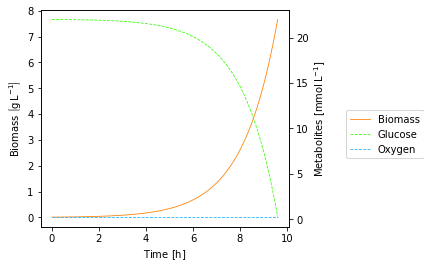

In [10]:
plot_concentrations(concentrations)

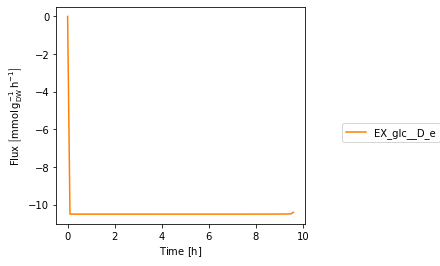

In [11]:
plot_trajectories(trajectories)

**Adding production of 5-HTP**

In [42]:
from cobra.io import read_sbml_model
from cobra.io import write_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd
from os.path import dirname, join, pardir

from cobra.io import read_sbml_model

from dfba import DfbaModel, ExchangeFlux, KineticVariable
from cobra.flux_analysis import flux_variability_analysis
# from dfba.plot.plotly import *
from dfba.plot.matplotlib import *

In [43]:
# Defining model
fba_model = read_sbml_model('data/iML1515_fs.xml')
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

In [44]:
fba_model.reactions.phhA

Reaction identifier,phhA
Name,
Memory address,0x07f2a5008fbb0
Stoichiometry,o2_c + thmnp_c + trp__L_c --> hthpth_c + htrp_c O2 O2 + Tetrahydromonapterin + L-Tryptophan --> +
GPR,
Lower bound,0.0
Upper bound,1000.0


In [45]:
# setting the flux of 5htp to the flux at half growth
#fba_model.reactions.phhA.flux = flux_variability_analysis(fba_model, fba_model.reactions.phhA, fraction_of_optimum = 0.5)["maximum"][0]
#print(fba_model.reactions.phhA.flux)

#model.optimize().objective_value
#solution = fba_model.optimize()

In [46]:
X = KineticVariable("Biomass")
HTP = KineticVariable("5HTP")
Gluc = KineticVariable("Glucose")
Oxy = KineticVariable("Oxygen")

dfba_model.add_kinetic_variables([X, HTP, Gluc, Oxy])

In [47]:
# Exchange fluxes
mu_bio = ExchangeFlux("BIOMASS_Ec_iML1515_core_75p37M")
v_htp = ExchangeFlux("EX_htrp")
v_GL = ExchangeFlux("EX_glc__D_e")
v_O = ExchangeFlux("EX_o2_e")


dfba_model.add_exchange_fluxes([mu_bio, v_htp, v_GL, v_O])

In [48]:
# Rhs expressions
dfba_model.add_rhs_expression("Biomass", mu_bio * X)
dfba_model.add_rhs_expression("5HTP", v_htp * 220.23/1000 * X)
dfba_model.add_rhs_expression("Glucose", v_GL * 180.1559/1000 * X) # v_GL [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant


In [49]:
# Adding bounds for oxygen
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)

In [50]:
# Adding bounds for glucose
vmax_glc = 10.5 # [mmol gDW^-1 h^-1]
Kg = 0.0027 # g/L Glucose Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_glc__D_e", vmax_glc * (Gluc / (Kg + Gluc)), Gluc)

In [51]:
#dfba_model.add_exchange_flux_lb(
#    "EX_htrp", 0, 2 # some fixed value for the bounds of 5htp exchange
#)

In [52]:
# add initial conditions and launch simulation
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.01, # (gDW/L)
        "5HTP": 0.00, # (gDW/L)
        "Glucose": 22.0, # (g/L)   [Kopp et al. 2018]
        "Oxygen": 0.24,  # (mmol/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 30.0, 0.1, ["EX_glc__D_e","EX_htrp"])

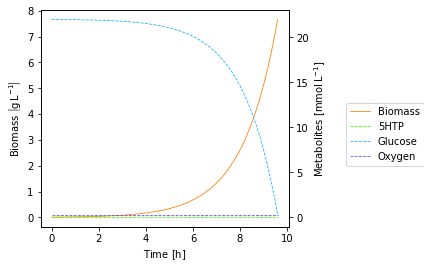

In [53]:
plot_concentrations(concentrations)

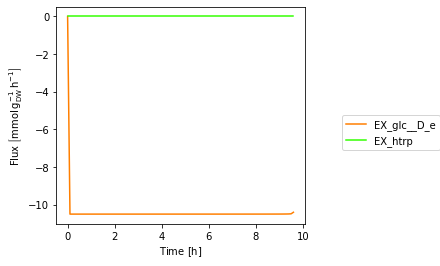

In [54]:
plot_trajectories(trajectories)

**Trying to include glycerol**

In [38]:
from os.path import dirname, join, pardir

from cobra.io import read_sbml_model

from dfba import DfbaModel, ExchangeFlux, KineticVariable

In [39]:
# Defining model
fba_model = read_sbml_model("data/iML1515.xml")
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

In [40]:
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Glyc = KineticVariable("Glycerol")
Oxy = KineticVariable("Oxygen")

dfba_model.add_kinetic_variables([X, Gluc, Glyc, Oxy])

In [41]:
# Exchange fluxes
mu = ExchangeFlux("BIOMASS_Ec_iML1515_core_75p37M")
v_GL = ExchangeFlux("EX_glc__D_e")
v_GY = ExchangeFlux("EX_glyc_e")
v_O = ExchangeFlux("EX_o2_e")


dfba_model.add_exchange_fluxes([mu, v_GL, v_GY, v_O])

In [42]:
# Rhs expressions
dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Glucose", v_GL * 180.1559/1000 * X) # v_GL [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
dfba_model.add_rhs_expression("Glycerol", v_GY *  92.09/1000 * X)
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant


In [43]:
# Adding bounds for oxygen
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)

In [44]:
vmax_glc = 10.5 # [mmol gDW^-1 h^-1]
Kg = 0.0027 # g/L Glucose Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_glc__D_e", vmax_glc * (Gluc / (Kg + Gluc)), Gluc)

In [45]:
#vmax_gly = 10.5 # [mmol gDW^-1 h^-1]
#Kg = 0.0027 # g/L Glucose Michaelis-Mentent constant ??
#dfba_model.add_exchange_flux_lb("EX_glc__D_e", vmax_gly * (Glyc / (Kg + Glyc)), Glyc)

In [46]:
# Glycerol is inhibited by Glycose
#vmax_gly = 10.5 # [mmol gDW^-1 h^-1]
#Kg = vmax_gly*15.5/-solution.fluxes["EX_glc__D_e"] #0.0027 # g/L Glucose Michaelis-Mentent constant
#Kie = 20 # g/L Ethanol inhibition constant
#dfba_model.add_exchange_flux_lb(
#    "EX_glyc_e",
#    vmax_gly * (Glyc / (Kg + Glyc)) * (1 / (1 + Gluc / Kie)),
#    Gluc
#)
#print(Kg)

In [47]:
# glycerol is inhibited by glycose
#vmax_gly = v_GY # [mmol gDW^-1 h^-1]
#Kgly = 0.0165 # g/L glycerol Michaelis-Mentent constant
#Kiglu = 0.005 # g/L Glucose inhibition constant
#dfba_model.add_exchange_flux_lb(
#    "EX_glyc_e",
#    vmax_gly * (Glyc / (Kgly + Glyc)) * (1 / (1 + Gluc / Kiglu)),
#    Glyc,
#)

In [48]:
# add initial conditions and launch simulation
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.01, # (gDW/L)
        "Glucose": 22.0, # (g/L)   [Kopp et al. 2018]
        "Glycerol": 23.0,   # (g/L)
        "Oxygen": 0.24,  # (mmol/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 12.0, 0.1, ["EX_glc__D_e", "EX_glyc_e"])

In [49]:
# from dfba.plot.plotly import *
from dfba.plot.matplotlib import *

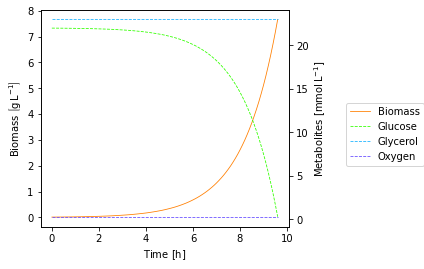

In [50]:
plot_concentrations(concentrations)

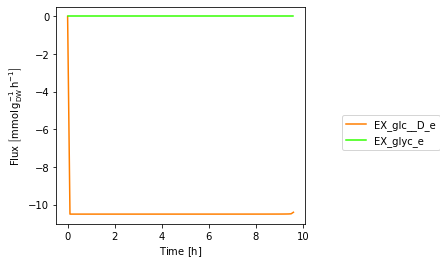

In [51]:
plot_trajectories(trajectories)

## Growth vs. Product yield

In [7]:
from cobra.io import read_sbml_model
from cobra.io import write_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd
from cobra.flux_analysis.phenotype_phase_plane import production_envelope

In [5]:
model = read_sbml_model('data/iML1515_fs.xml')

In [11]:
# using the relation between biomass and 5HTP production
ppp_5HTP = production_envelope(model,
                    reactions=[model.reactions.phhA],
                    objective=model.reactions.BIOMASS_Ec_iML1515_core_75p37M)

In [12]:
ppp_5HTP

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,phhA
0,EX_glc__D_e,0.0,0.0,NaN,0.876997,1.161751e+01,NaN,0.000000
1,EX_glc__D_e,0.0,0.0,NaN,0.831248,1.101147e+01,NaN,0.225221
2,EX_glc__D_e,0.0,0.0,NaN,0.785499,1.040543e+01,NaN,0.450443
3,EX_glc__D_e,0.0,0.0,NaN,0.739749,9.799397e+00,NaN,0.675664
4,EX_glc__D_e,0.0,0.0,NaN,0.694000,9.193359e+00,NaN,0.900885
5,EX_glc__D_e,0.0,0.0,NaN,0.647766,8.580901e+00,NaN,1.126106
6,EX_glc__D_e,0.0,0.0,NaN,0.601497,7.967979e+00,NaN,1.351328
7,EX_glc__D_e,0.0,0.0,NaN,0.555228,7.355058e+00,NaN,1.576549
8,EX_glc__D_e,0.0,0.0,NaN,0.508959,6.742136e+00,NaN,1.801770
9,EX_glc__D_e,0.0,0.0,NaN,0.462690,6.129215e+00,NaN,2.026992


In [17]:
# making a list of growthrates and product fluxes
bio_growth = ppp_5HTP["flux_maximum"].tolist()
htp_flux = ppp_5HTP["phhA"].tolist()

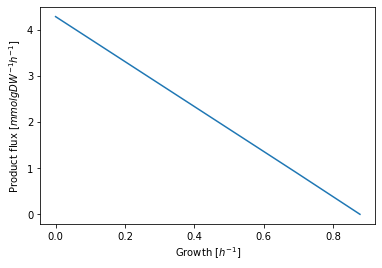

In [20]:
import matplotlib.pyplot as plt
plt.plot(bio_growth, htp_flux)
plt.xlabel('Growth [$h^{-1}$]')
plt.ylabel('Product flux [$mmol gDW^{-1} h^{-1}$]')
plt.show()